In [2]:
# 1. 파이썬 코드에서 Matplotlib 폰트 설정
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import timedelta
from itertools import combinations
from collections import Counter

# 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정이 완료되었습니다.")


한글 폰트 설정이 완료되었습니다.


In [3]:
# 3. 데이터 로드 및 통합 (모든 문제 풀이의 시작점)
# dataframe 확인해라!
try:
    orders_df = pd.read_csv('../data/orders.csv')
    payments_df = pd.read_csv('../data/payments.csv')
    products_df = pd.read_csv('../data/products.csv')
    shipping_df = pd.read_csv('../data/shipping.csv')
    customers_df = pd.read_csv('../data/customers.csv')

    # 모든 데이터프레임 병합
    df = pd.merge(orders_df, payments_df, on='order_id', how='left')
    df = pd.merge(df, products_df, on='product_id', how='left')
    df = pd.merge(df, customers_df, on='customer_id', how='left')
    df = pd.merge(df, shipping_df, on='order_id', how='left')

    # 데이터 전처리
    date_cols = ['order_date', 'payment_date', 'join_date', 'shipping_start_date', 'shipping_end_date']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    df['total_sales'] = df['quantity'] * df['price']
    
    print("데이터 로드 및 통합이 완료되었습니다.")

except FileNotFoundError as e:
    print(f"파일을 찾을 수 없습니다: {e}")


데이터 로드 및 통합이 완료되었습니다.


In [4]:
# 문제 1: 카테고리별 월별 매출액 추이를 분석하고, 가장 성장률이 높은 카테고리를 식별하세요.
# 시각화: 라인 플롯

# 비즈니스 목적: 시간에 따른 카테고리별 성과를 파악하여 어떤 카테고리에 집중해야 할지 결정합니다.
df.columns

Index(['order_id', 'customer_id', 'product_id', 'order_date', 'quantity',
       'payment_id', 'payment_method', 'payment_status', 'payment_date',
       'product_name', 'category', 'price', 'stock', 'name', 'gender', 'age',
       'join_date', 'city', 'shipping_id', 'shipping_company',
       'shipping_status', 'shipping_start_date', 'shipping_end_date',
       'total_sales'],
      dtype='object')

In [4]:
# 출력 결과를 보고 코딩하세요
# 카테고리별 평균 월별 성장률 구하기 

# 1.1. 년-월 컬럼 추가
df['year_month'] = df['order_date'].dt.to_period('M') # 2023-10 ~ 2025-10 으로 추려내기
# df['year_month']  
# df.head()


In [ ]:
# 1.2. 카테고리별, 월별 매출 집계
# monthly_sales = df.groupby(['category', 'year_month'])['total_sales'].sum().unstack()
monthly_sales = df.groupby(['category', 'year_month'])['total_sales'].sum()
print(monthly_sales)

category  year_month
가구        2023-10        3165100
          2023-11       10030900
          2023-12        9636900
          2024-01       11262300
          2024-02        6671000
                          ...   
화장품       2025-06        9006000
          2025-07       12253100
          2025-08        8121600
          2025-09        6538700
          2025-10        6454300
Name: total_sales, Length: 175, dtype: int64


In [6]:
# 1.3. 평균 월별 성장률 계산 
result_series = (monthly_sales
                 .groupby(level='category')
                 .pct_change()
                 .groupby(level='category')
                 .mean()
                 .sort_values(ascending=False))
result_series.name = None

## 첫번째 출력물
print("카테고리별 평균 월별 성장률:")
print(result_series)

카테고리별 평균 월별 성장률:
category
화장품      0.127811
가구       0.098994
식품       0.087353
의류       0.079554
도서       0.078011
스포츠용품    0.073715
전자제품     0.048982
dtype: float64


In [7]:
# 1.4. 월별 성장률 추이 그래프 (result_series 순서대로) 만들기 
monthly_growth = monthly_sales.groupby(level='category').pct_change() * 100
print(monthly_growth)


category  year_month
가구        2023-10              NaN
          2023-11       216.922056
          2023-12        -3.927863
          2024-01        16.866420
          2024-02       -40.766984
                           ...    
화장품       2025-06        -5.214966
          2025-07        36.054852
          2025-08       -33.717998
          2025-09       -19.490002
          2025-10        -1.290776
Name: total_sales, Length: 175, dtype: float64


In [23]:
print(df['year_month'].unique().size)

25


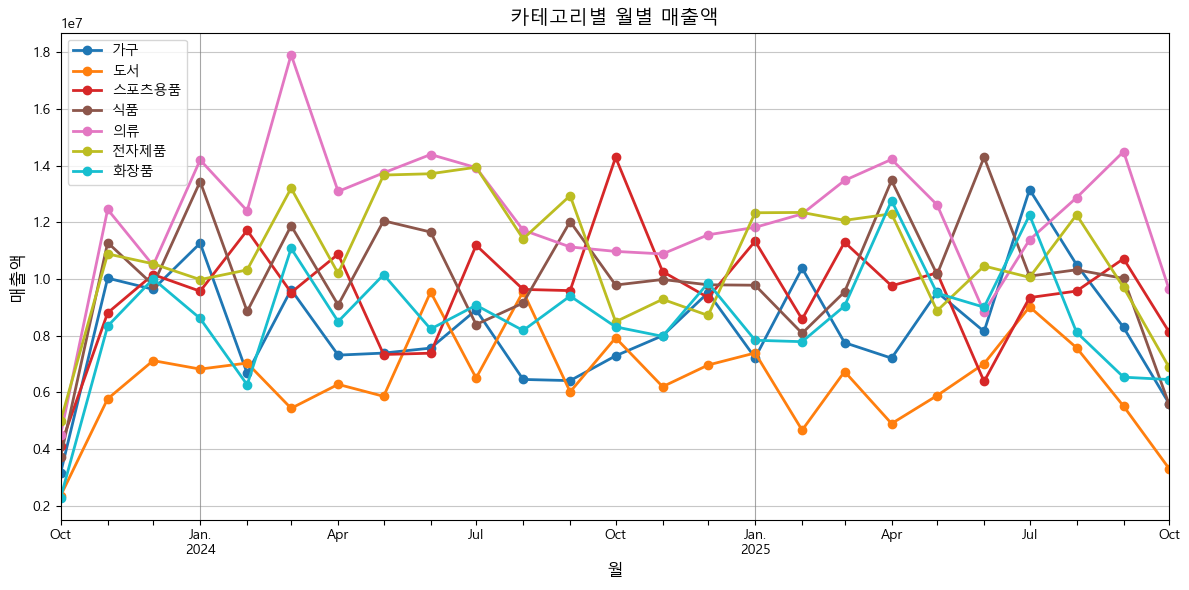

In [10]:
import matplotlib.cm as cm    # 컬러 메소드 사용하기 위해
from datetime import datetime # x축 label용

# 멀티 인덱스: level 0 = category, level 1 = month
categories = monthly_sales.index.levels[0]

# 1.5 그래프로 그리기 
plt.figure(figsize=(12, 6))

# 1.5.1 선 그래프별 색상 만들기
colors = cm.tab10(np.linspace(0, 1, len(monthly_sales.index.levels[0])))

# 1.5.2 카테고리별로 그래프 만들기
for i, category in enumerate(monthly_sales.index.levels[0]):
    monthly_data = monthly_sales.xs(category, level=0)
    monthly_data.index = monthly_data.index.to_timestamp()
    
    plt.plot(monthly_data.index,
             monthly_data.values,
             marker='o',
             label=category,
             linewidth=2,
             color=colors[i])

plt.xlabel('월', fontsize=12)
plt.ylabel('매출액', fontsize=12)
plt.title('카테고리별 월별 매출액', fontsize=14, fontweight='normal')
plt.legend(loc='upper left', fontsize=10)


# 3개월 단위 Period 범위 생성    
# x축 설정
xticks = df['year_month'].unique()
xtick_to_timestamp = xticks.to_timestamp() #ticks 는 timestamp 형식으로 줘야 함 monthly_data.index.to_timestamp() 으로 했기 때문에
xlabels = []

for ym in xticks:
    month = ym.month
    
    # 1월: 연도 포함
    if month == 1:
        xlabels.append(ym.strftime('%b.\n%Y'))
    # 3개월 단위 (4, 7, 10월)
    elif month in [4, 7, 10]:
        xlabels.append(ym.strftime('%b'))
    # 나머지: 빈 레이블
    else:
        xlabels.append('')
# print(xlabels)     # 검증 ['Oct', '', '', 'Jan.\n2024', '', '', 'Apr', '', '', 'Jul', '', '', 'Oct', '', '', 'Jan.\n2025', '', '', 'Apr', '', '', 'Jul', '', '', 'Oct']

plt.xticks(ticks=xtick_to_timestamp, labels=xlabels, rotation=0, ha='center')

# 첫 번째와 마지막 timestamp 기준으로
plt.xlim(xtick_to_timestamp[0], xtick_to_timestamp[-1])

# 그리드 설정
plt.grid(axis='y', linestyle='-', alpha=0.7)  # y축만 기본 그리드

# 1월 위치에만 수직 그리드선 추가
for i, ym in enumerate(xtick_to_timestamp):
    if ym.month == 1:
        plt.axvline(x=xtick_to_timestamp[i], color='gray', linestyle='-', linewidth=0.8, alpha=0.7)

plt.tight_layout()
plt.show()
